In [30]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc

In [31]:
fuel_material = openmc.Material(name="Natural UO2 Fuel")
fuel_material.add_nuclide('U235', 0.0072)  
fuel_material.add_nuclide('U238', 0.9928) 
fuel_material.add_element('O', 2)
fuel_material.set_density('g/cm3', 10.5)

In [32]:
cladding = openmc.Material(name="Zirconium Cladding")
cladding.add_element('Zr', 1)
cladding.set_density('g/cm3', 6.55)  

In [33]:
coolant = openmc.Material(name="Heavy Water (D2O)")
coolant.add_element('H', 2)  
coolant.add_element('O', 1)
coolant.set_density('g/cm3', 1.11)  

In [34]:
# Outer radius of fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

# Pressure tube and calendria radii
#pressure_tube_ir = 5.16890
#pressure_tube_or = 5.60320
pressure_tube_ir = 3.6689
pressure_tube_or = 3.9031
calendria_ir = 4.6677
calendria_or = 4.8075
#calendria_ir = 6.44780
#calendria_or = 6.58750

# Radius to center of each ring of fuel pins
ring_radii = np.array([0.0, 1.4885, 2.8755])

In [35]:
# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
        
    water_cells.append(openmc.Cell(fill=coolant, region=water_region))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

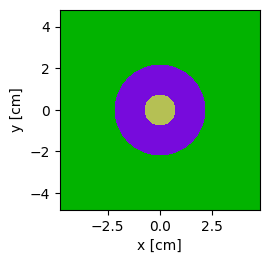

In [36]:
plot_args = {'width': (2*calendria_or, 2*calendria_or)}
bundle_universe = openmc.Universe(cells=water_cells)
bundle_universe.plot(**plot_args)

In [37]:
surf_fuel = openmc.ZCylinder(r=r_fuel)

fuel_cell = openmc.Cell(fill=fuel_material, region=-surf_fuel)
clad_cell = openmc.Cell(fill=cladding, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

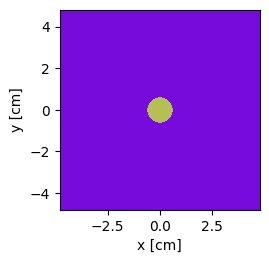

In [38]:
pin_universe.plot(**plot_args)

In [39]:
num_pins = [1, 6, 12]
angles = [0, 0, 15]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        water_cells[i].region &= +pin_boundary
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=100.
  warn(msg, IDWarning)
/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=200.
  warn(msg, IDWarning)
/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=201.
  warn(msg, IDWarning)
/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=202.
  warn(msg, IDWarning)
/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=203.
  warn(msg, IDWarning)
/Users/kavyawadhwa/Anaconda/anaconda3/envs/openmc/lib/python3.13/site-packages/openmc

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

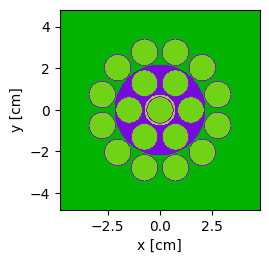

In [40]:
bundle_universe.plot(**plot_args)

In [41]:
pt_inner = openmc.ZCylinder(r=pressure_tube_ir)
pt_outer = openmc.ZCylinder(r=pressure_tube_or)
calendria_inner = openmc.ZCylinder(r=calendria_ir)
calendria_outer = openmc.ZCylinder(r=calendria_or, boundary_type='vacuum')

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=cladding, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=cladding, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(cells=[bundle, pressure_tube, v1, calendria])

In [42]:
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

materials = openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

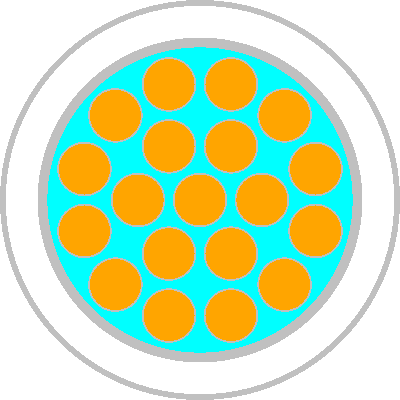

In [43]:
plot = openmc.Plot.from_geometry(geometry)
plot.color_by = 'material'
plot.colors = {
    fuel_material: 'orange',
    cladding: 'silver',
    coolant: 'cyan'
}
plot.to_ipython_image()

In [20]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 200
settings.inactive = 10
settings.source = openmc.IndependentSource(space=openmc.stats.Point())
settings.output = {'tallies' : False}
settings.export_to_xml()

In [21]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]
fuel_tally.scores = ['flux']

tallies = openmc.Tallies([fuel_tally])
tallies.export_to_xml()

In [22]:
openmc.run(output=True)

[KAVYAs-MacBook-Air.local:41596] shmem: mmap: an error occurred while determining whether or not /var/folders/r_/4w66l1vj4tlgqqxv9j741qdr0000gn/T//ompi.KAVYAs-MacBook-Air.501/jf.0/1787887616/sm_segment.KAVYAs-MacBook-Air.501.6a910000.0 could be created.
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                ##################### 